In [70]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ks_2samp
from sklearn.metrics import matthews_corrcoef
import warnings
warnings.filterwarnings("ignore")

In [2]:
dataset = pd.read_csv('https://raw.githubusercontent.com/Doll03/4IZ480/main/Data/TimeDeposit_10K.csv', sep=";")


In [3]:
dataset.Time_Deposits_Flag.value_counts()


F    9897
T     103
Name: Time_Deposits_Flag, dtype: int64

In [4]:
dataset["Customer_ID"] = dataset["Customer_ID"].astype("object")
dataset["Birth_Date"] = dataset["Birth_Date"].astype("datetime64")
dataset["Ref_Date"] = dataset["Ref_Date"].astype("datetime64")
dataset["Gender"] = [True if i == "Male" else False for i in dataset['Gender']]# 1=Male 0=Female
dataset["Marital_Status"] = dataset["Marital_Status"].astype("category")
dataset["Children_Num"] = dataset["Children_Num"].astype("category")
dataset["Occupation_Category"] = dataset["Occupation_Category"].astype("category")
dataset["Payroll_Flag"] = dataset["Payroll_Flag"].astype("bool")
dataset["Business_Flag"] = dataset["Business_Flag"].astype("bool")
dataset["Saving_Current_Accounts_Flag"] = dataset["Saving_Current_Accounts_Flag"].astype("bool")
dataset["Investment_Products_Flag"] = dataset["Investment_Products_Flag"].astype("bool")
dataset["Insurance_Products_Flag"] = dataset["Insurance_Products_Flag"].astype("bool")
dataset["Business_Loans_Flag"] = dataset["Business_Loans_Flag"].astype("bool")
dataset["Housing_Loans_Flag"] = dataset["Housing_Loans_Flag"].astype("bool")
dataset["Consumer_Loans_Flag"] = dataset["Consumer_Loans_Flag"].astype("bool")
dataset["Credit_Cards_Flag"] = dataset["Credit_Cards_Flag"].astype("bool")
dataset["Time_Deposits_Flag"] = [True if i == "T" else False for i in dataset['Time_Deposits_Flag']]



In [5]:
dataset.Time_Deposits_Flag.value_counts()


False    9897
True      103
Name: Time_Deposits_Flag, dtype: int64

In [6]:
#Creating boolean variables 
dataset["Credit_Cards_Installments_Flag"] = [True if i > 0 else False for i in dataset['Credit_Cards_Installments']]
dataset["Credit_Cards_Payments_Flag"] = [True if i > 0 else False for i in dataset['Credit_Cards_Payments_Num']]
dataset["Credit_Cards_Purchases_Flag"] = [True if i > 0 else False for i in dataset['Credit_Cards_Purchases_Num']]
dataset["Credit_Cards_Witrhdrawals_Flag"] = [True if i > 0 else False for i in dataset['Credit_Cards_Witrhdrawals_Num']]
dataset["Internet_Trans_Flag"] = [True if i > 0 else False for i in dataset['Internet_Trans_Num']]
dataset["Deposit_Trans_Flag"] = [True if i > 0 else False for i in dataset['Deposit_Trans_Num']]
dataset["Payment_Trans_Flag"] = [True if i > 0 else False for i in dataset['Payment_Trans_Num']]
dataset["Transfer_Trans_Flag"] = [True if i > 0 else False for i in dataset['Transfer_Trans_Num']]
dataset["Withdrawl_Trans_Flag"] = [True if i > 0 else False for i in dataset['Withdrawl_Trans_Num']]

In [7]:
#Creating variable Age_Cat
dataset['Age'] = dataset['Ref_Date'].dt.year - dataset['Birth_Date'].dt.year
Age_Cat = pd.cut(dataset['Age'], bins=[0, 32.50, 51.50, 60.50, 150],labels=['Younger', 'LowerMid', 'UpperMid', 'Older'])
Age_Cat

0       LowerMid
1       LowerMid
2       UpperMid
3       UpperMid
4       LowerMid
          ...   
9995     Younger
9996    LowerMid
9997    LowerMid
9998    LowerMid
9999     Younger
Name: Age, Length: 10000, dtype: category
Categories (4, object): ['Younger' < 'LowerMid' < 'UpperMid' < 'Older']

In [8]:
#cat_v_list = [i for i in list(dataset.columns) if i not in num_v_list]
dataset['Time_Deposits_Flag']=dataset['Time_Deposits_Flag'].astype('category')

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 56 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Customer_ID                       10000 non-null  object        
 1   Gender                            10000 non-null  bool          
 2   Birth_Date                        10000 non-null  datetime64[ns]
 3   Ref_Date                          10000 non-null  datetime64[ns]
 4   Marital_Status                    10000 non-null  category      
 5   Children_Num                      10000 non-null  category      
 6   Occupation_Category               10000 non-null  category      
 7   Total_Income                      10000 non-null  float64       
 8   Payroll_Flag                      10000 non-null  bool          
 9   Business_Flag                     10000 non-null  bool          
 10  Saving_Current_Accounts_Flag      10000 non-nul

In [10]:
dataset = dataset.drop(["Ref_Date","Birth_Date","Customer_ID","Age" ], axis = "columns", errors="ignore")

In [11]:
#crealing list of categorical variables
cat_v_list = [i for i in list(dataset.columns) if (dataset[i].dtypes in ['O', 'bool', "category"])]
cat_v_list.remove('Time_Deposits_Flag')

#creating list of numerical variables
num_v_list = [i for i in list(dataset.columns) if i not in cat_v_list]
num_v_list.remove('Time_Deposits_Flag')
print("Num:", num_v_list, "end=", "Cat:", cat_v_list)


Num: ['Total_Income', 'Saving_Current_Balance', 'Investment_Products_Balance', 'Insurance_Balances', 'Business_Loans_Balance', 'Housing_Loans_Balance', 'Consumer_Loans_Balance', 'Credit_Cards_Balance', 'Branch_Trans_Num', 'ATM_Trans_Num', 'APS_Trans_Num', 'Phone_Trans_Num', 'Internet_Trans_Num', 'Deposit_Trans_Num', 'Withdrawl_Trans_Num', 'Payment_Trans_Num', 'Transfer_Trans_Num', 'Deposit_Trans_Amount', 'Withdrawl_Trans_Amount', 'Payment_Trans_Amount', 'Transfer_Trans_Amount', 'Credit_Cards_Installments', 'Credit_Cards_Payments_Num', 'Credit_Cards_Purchases_Num', 'Credit_Cards_Witrhdrawals_Num', 'Credit_Cards_Payments_Amount', 'Credit_Cards_Purchases_Amount', 'Credit_Cards_Witrhdrawals_Amount', 'Arrears_Months_Max'] end= Cat: ['Gender', 'Marital_Status', 'Children_Num', 'Occupation_Category', 'Payroll_Flag', 'Business_Flag', 'Saving_Current_Accounts_Flag', 'Investment_Products_Flag', 'Insurance_Products_Flag', 'Business_Loans_Flag', 'Housing_Loans_Flag', 'Consumer_Loans_Flag', 'Credit

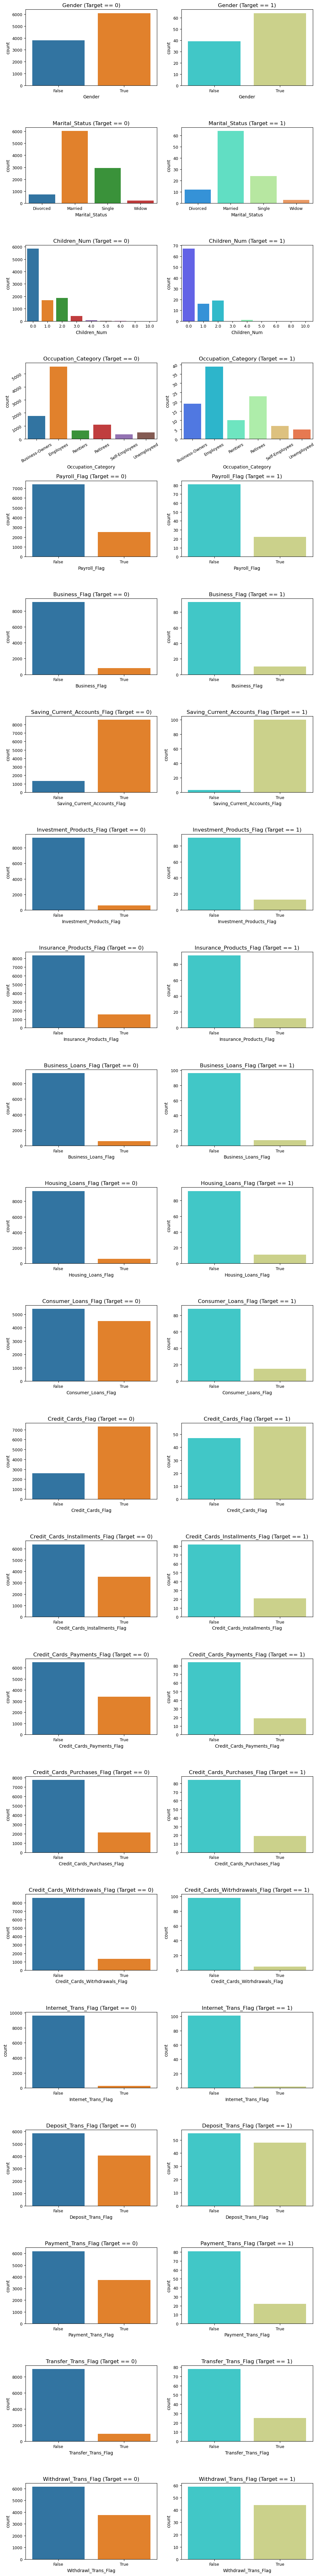

In [12]:
#Creating a list and graphs for storing categorical features.


figure,axis = plt.subplots(22,2, figsize=(10,80))

col_ind=0
axis_count = 0

for ax in axis.ravel():

    if axis_count % 2 == 0:
        sns.countplot(data=dataset[dataset["Time_Deposits_Flag"] == False], x=cat_v_list[col_ind], ax = ax)
        ax.set_title(cat_v_list[col_ind]+" (Target == 0)")

        if cat_v_list[col_ind] == "Occupation_Category":
            ax.tick_params(axis='both', which='major', labelsize=9, rotation = 30)
        else:
            ax.tick_params(axis='both', which='major', labelsize=9)
        
    else:
        sns.countplot(data=dataset[dataset["Time_Deposits_Flag"] == True], x=cat_v_list[col_ind], ax = ax, palette='rainbow')
        ax.set_title(cat_v_list[col_ind]+" (Target == 1)")

        if cat_v_list[col_ind] == "Occupation_Category":
            ax.tick_params(axis='both', which='major', labelsize=9, rotation = 30)
        else:
            ax.tick_params(axis='both', which='major', labelsize=9)

        col_ind += 1
        
    axis_count +=1

plt.tight_layout()
plt.show()

In [100]:
list(dataset[cat_v_list].describe().transpose().index)

['Gender',
 'Marital_Status',
 'Children_Num',
 'Occupation_Category',
 'Payroll_Flag',
 'Business_Flag',
 'Saving_Current_Accounts_Flag',
 'Investment_Products_Flag',
 'Insurance_Products_Flag',
 'Business_Loans_Flag',
 'Housing_Loans_Flag',
 'Consumer_Loans_Flag',
 'Credit_Cards_Flag',
 'Credit_Cards_Installments_Flag',
 'Credit_Cards_Payments_Flag',
 'Credit_Cards_Purchases_Flag',
 'Credit_Cards_Witrhdrawals_Flag',
 'Internet_Trans_Flag',
 'Deposit_Trans_Flag',
 'Payment_Trans_Flag',
 'Transfer_Trans_Flag',
 'Withdrawl_Trans_Flag']

In [101]:
cat_vars = list(dataset[cat_v_list].describe().transpose().index)+["Time_Deposits_Flag"]

for i in cat_vars:
    dataset[i] = dataset[i].astype("category")
cat_corr_mat = pd.DataFrame(columns = cat_vars, index = cat_vars)

for row in cat_corr_mat.index:
    for col in cat_corr_mat.columns:
        if (dataset[row].nunique() == 2) and ((dataset[col].nunique() == 2)):
            bin_var1, bin_var2 = dataset[col].astype("int"), dataset[row].astype("int")
            phi = matthews_corrcoef(bin_var1, bin_var2)
            cat_corr_mat.loc[row, col] = phi
        elif (dataset[row].nunique() > 2) or ((dataset[col].nunique() > 2)):
            data_crosstab = pd.crosstab(dataset[row], dataset[col])
            chi2, _, ___, ____ = chi2_contingency(data_crosstab, correction=False)
            cramer = np.sqrt(chi2/data_crosstab.sum().sum())/ (min(data_crosstab.shape) -1)
            cat_corr_mat.loc[row, col] = cramer
cat_corr_mat

,Gender,Marital_Status,Children_Num,Occupation_Category,Payroll_Flag,Business_Flag,Saving_Current_Accounts_Flag,Investment_Products_Flag,Insurance_Products_Flag,Business_Loans_Flag,...,Credit_Cards_Installments_Flag,Credit_Cards_Payments_Flag,Credit_Cards_Purchases_Flag,Credit_Cards_Witrhdrawals_Flag,Internet_Trans_Flag,Deposit_Trans_Flag,Payment_Trans_Flag,Transfer_Trans_Flag,Withdrawl_Trans_Flag,Time_Deposits_Flag
Gender,1.0,0.064373,0.052235,0.088933,-0.087323,0.068738,0.044005,-0.022863,0.016285,0.078136,...,-0.013426,-0.012614,-0.048326,0.032302,0.028005,0.052559,0.034361,0.013492,-0.031664,0.001166
Marital_Status,0.064373,0.57735,0.173188,0.113375,0.114699,0.071486,0.060302,0.062563,0.085872,0.071439,...,0.058731,0.057558,0.044857,0.045673,0.043344,0.041945,0.066488,0.025355,0.087918,0.020579
Children_Num,0.052235,0.173188,0.353553,0.048478,0.057933,0.085864,0.021147,0.04967,0.042345,0.086147,...,0.01945,0.024095,0.022199,0.026121,0.031198,0.036504,0.043598,0.021858,0.046676,0.023089
Occupation_Category,0.088933,0.113375,0.048478,0.447214,0.261287,0.441029,0.038752,0.03605,0.027344,0.367203,...,0.049781,0.04648,0.060642,0.032671,0.052749,0.0962,0.088957,0.084033,0.093773,0.047744
Payroll_Flag,-0.087323,0.114699,0.057933,0.261287,1.0,-0.142585,0.195449,-0.077686,-0.076329,-0.119432,...,-0.008279,-0.011377,0.031625,-0.015285,0.050607,-0.081752,-0.174675,0.066307,0.473583,-0.009047
Business_Flag,0.068738,0.071486,0.085864,0.441029,-0.142585,1.0,0.044922,-0.031689,0.017548,0.819254,...,0.014841,0.016234,0.007118,-0.001109,0.035679,0.197719,0.077114,0.130637,0.041843,0.006882
Saving_Current_Accounts_Flag,0.044005,0.060302,0.021147,0.038752,0.195449,0.044922,1.0,-0.137847,0.003624,0.019021,...,-0.111922,-0.113728,-0.052955,-0.058257,0.044237,0.285265,-0.076845,0.117019,0.260883,0.031567
Investment_Products_Flag,-0.022863,0.062563,0.04967,0.03605,-0.077686,-0.031689,-0.137847,1.0,-0.033754,-0.033247,...,-0.097566,-0.091781,-0.057283,-0.068446,0.016236,-0.07903,-0.113187,0.024982,-0.055134,0.027479
Insurance_Products_Flag,0.016285,0.085872,0.042345,0.027344,-0.076329,0.017548,0.003624,-0.033754,1.0,0.019994,...,0.16751,0.164325,0.103446,0.176589,0.024519,0.142576,0.264598,0.078019,-0.011969,-0.01133
Business_Loans_Flag,0.078136,0.071439,0.086147,0.367203,-0.119432,0.819254,0.019021,-0.033247,0.019994,1.0,...,0.010976,0.013839,0.003071,0.008567,0.019186,0.206965,0.092475,0.101596,0.039682,0.004347


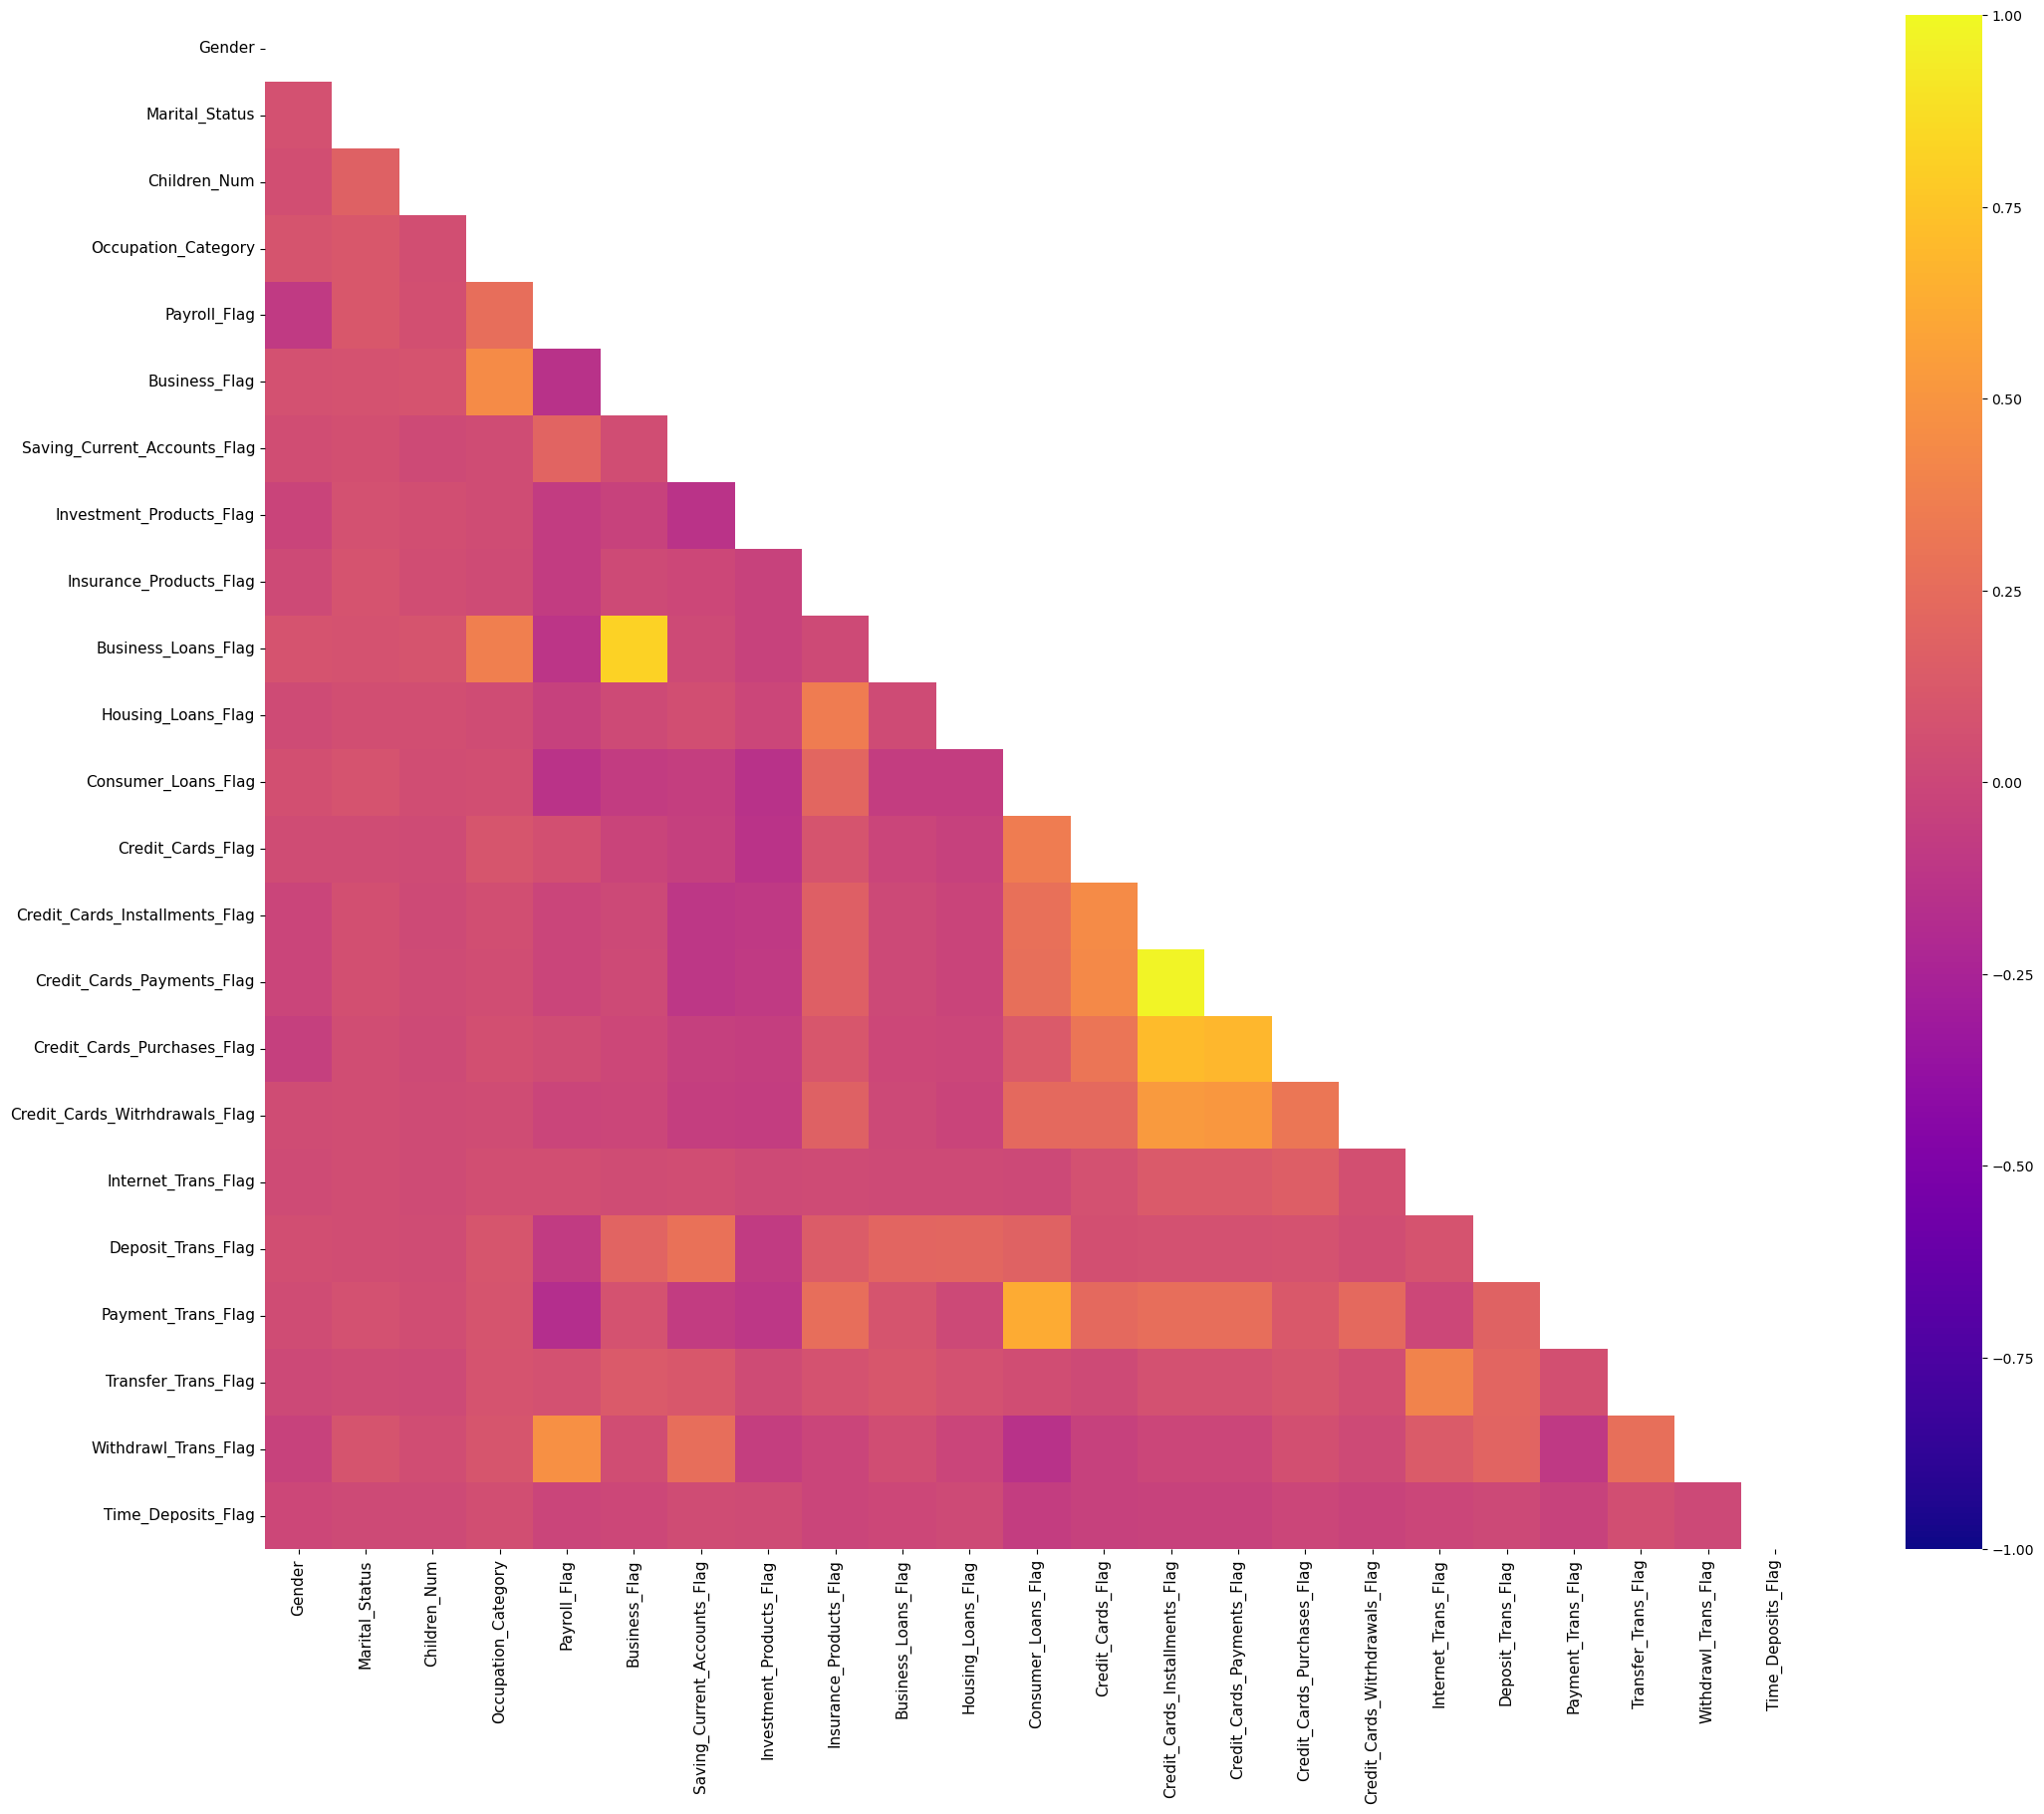

In [102]:
cat_corr_mat = cat_corr_mat.astype("float")
plt.figure(figsize = (25, 20))
mask = np.triu(np.ones_like(cat_corr_mat))
cax = sns.heatmap(cat_corr_mat, vmin = -1, vmax = 1, mask = mask, cmap = "plasma")
cax.tick_params(labelsize = 11)
plt.show()


In [71]:
#function for displaying contigency table and chi-square statistic

def chi_square(data, var1, var2 = "Time_Deposits_Flag", alpha = 0.05):


    data_crosstab = pd.crosstab(data[var1],data[var2], margins=True)

    chi2, p, dof, expected = chi2_contingency(data_crosstab, correction=False)

    print('The p-value is', p)
    print(expected)
    if p <= alpha:
        print(f'Result: We reject the null hypothesis: There is a relationship between {var1} and {var2}, therefore they are dependent.')
    else:
        print(f'Result: We fail to reject the null hypothesis: There is no relationship between {var1} and {var2}, therefore they are independent.')
    return data_crosstab

chi_square(dataset, "Gender")

<h1><b>TEST<b><h1>

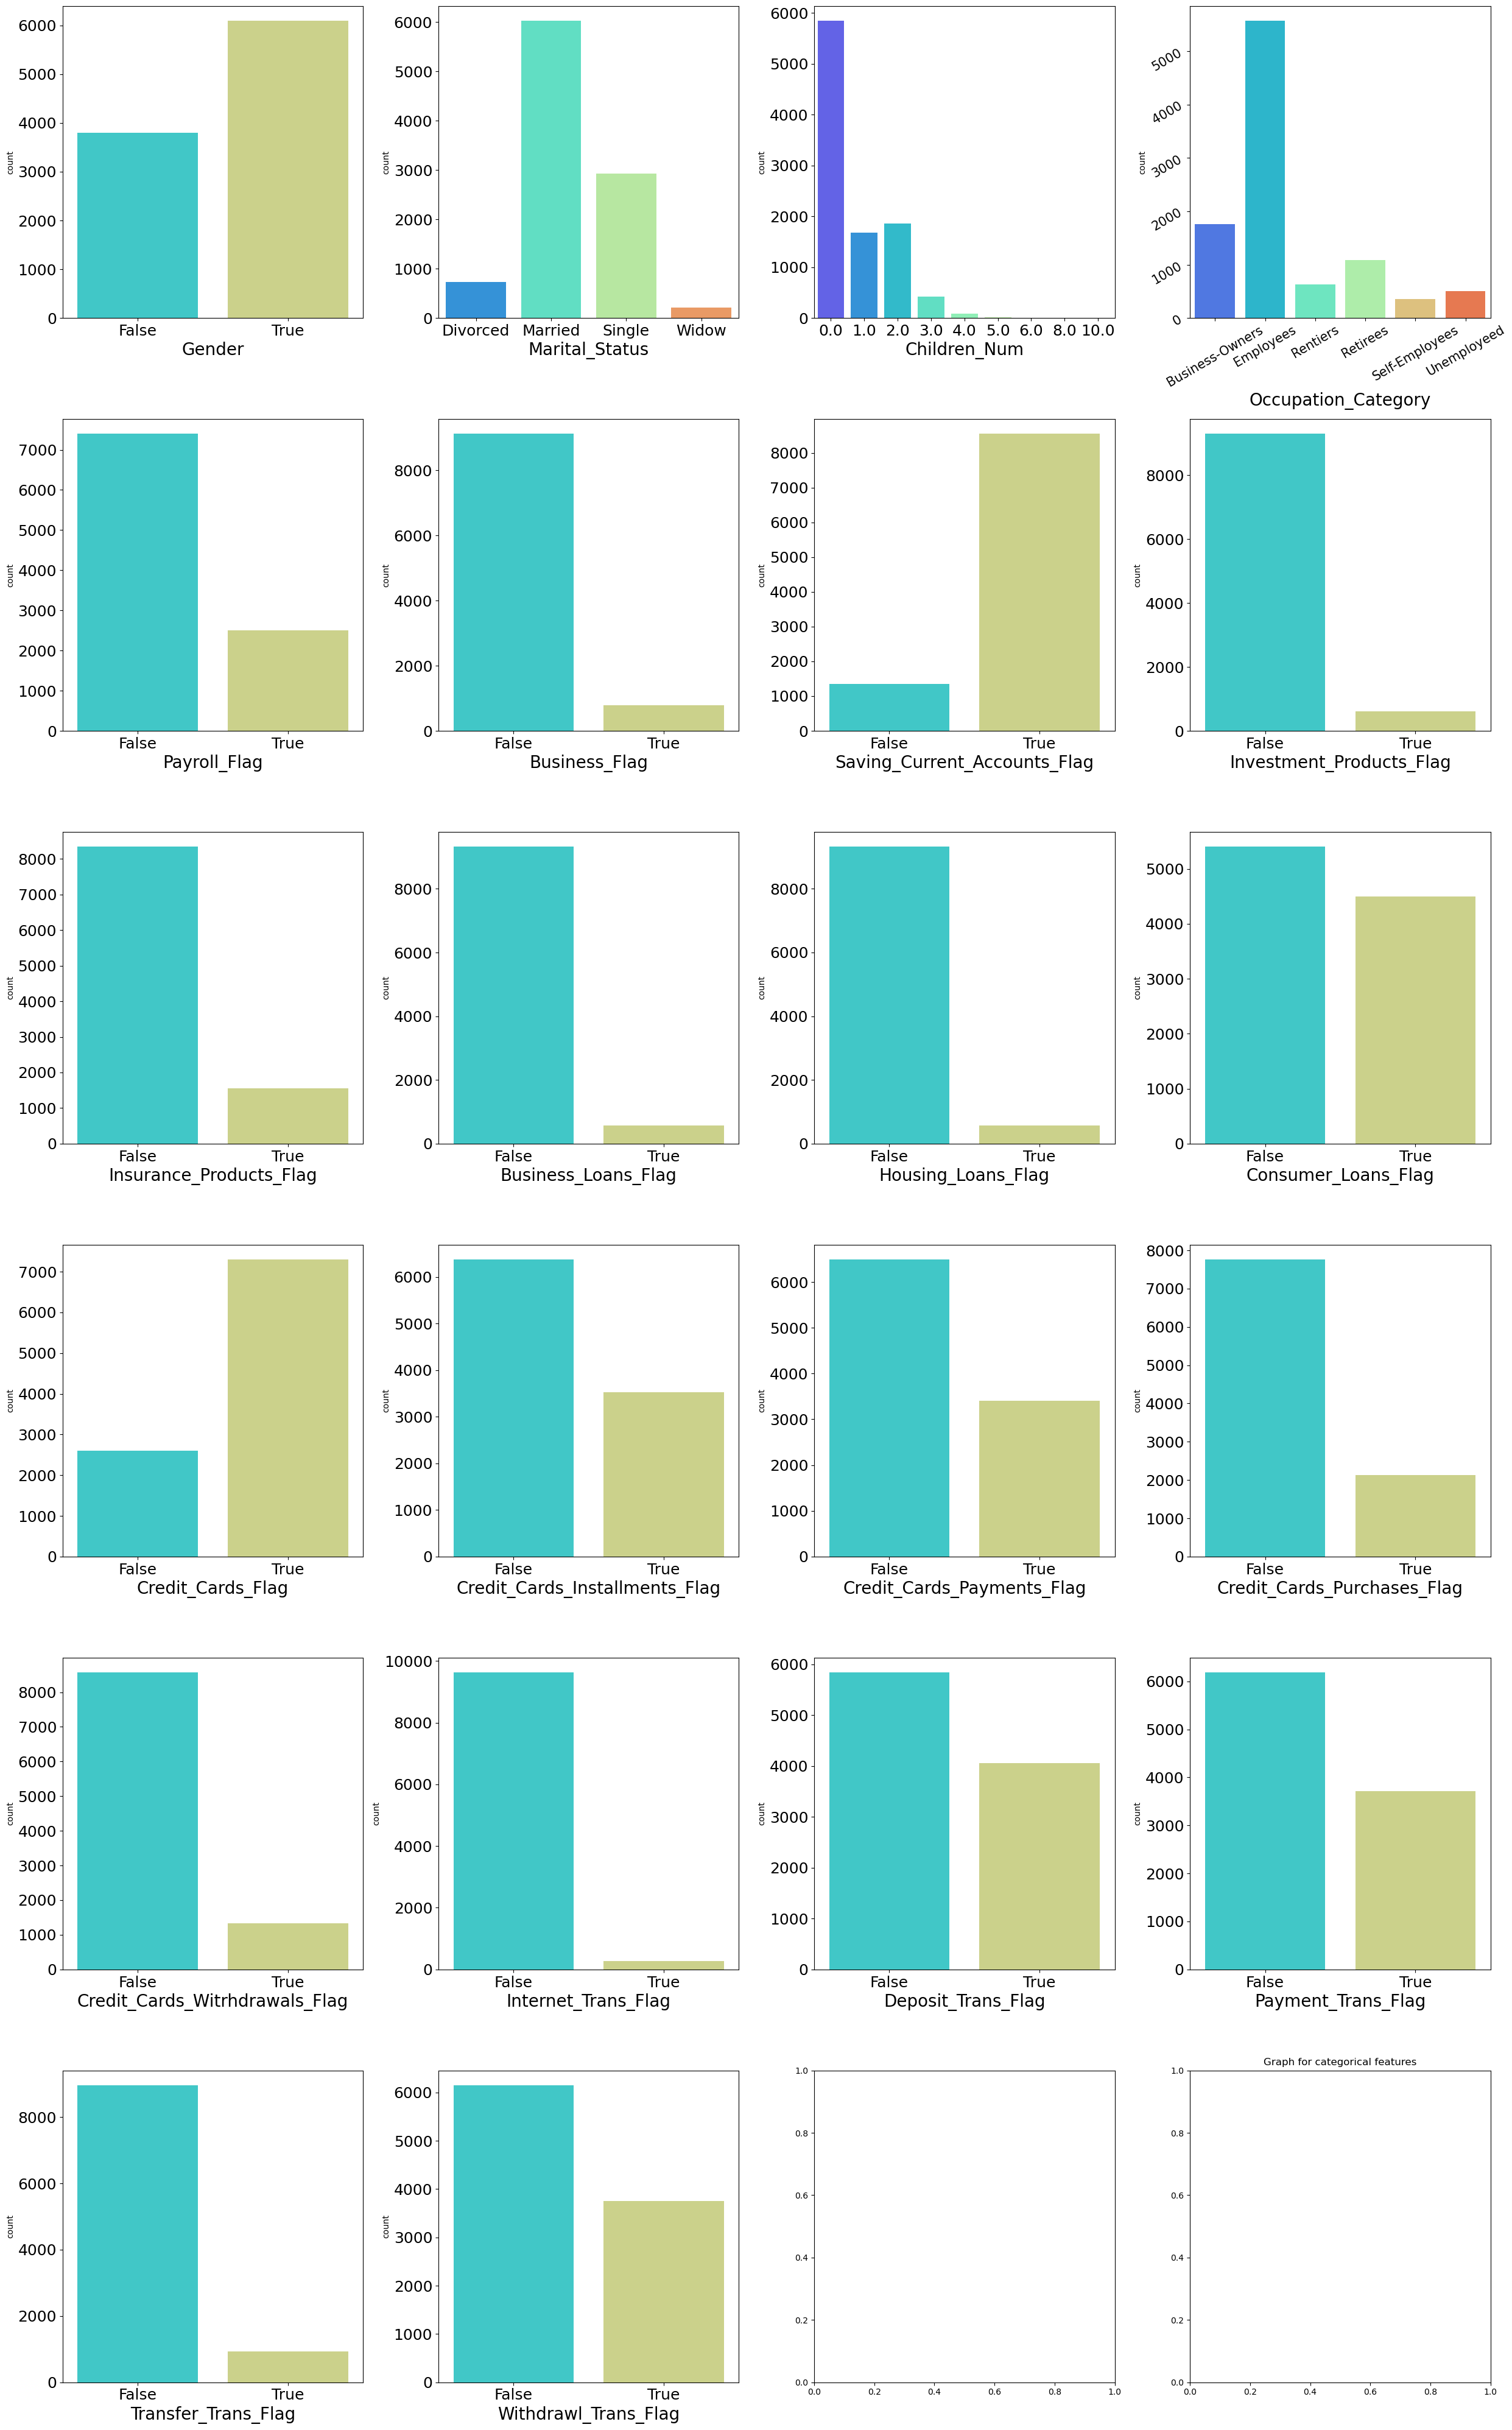

In [15]:
#Creating a list and graphs for storing categorical features.
#cat_v_list = [i for i in list(dataset.columns) if i not in num_v_list]
dataset['Time_Deposits_Flag']=dataset['Time_Deposits_Flag'].astype('category')

figure,axis = plt.subplots(6,4, figsize=(25,40))

for column,ax in zip(cat_v_list,axis.ravel()):
    sns.countplot(data=dataset[dataset["Time_Deposits_Flag"] == False], x=column, ax = ax, palette='rainbow')
    if column == "Occupation_Category":
        ax.tick_params(axis='both', which='major', labelsize=15, rotation = 30)
    else:
        ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_xlabel (column, size = 20) 

plt.title('Graph for categorical features')
plt.tight_layout()
plt.show()

False    0.9897
True     0.0103
Name: Time_Deposits_Flag, dtype: float64


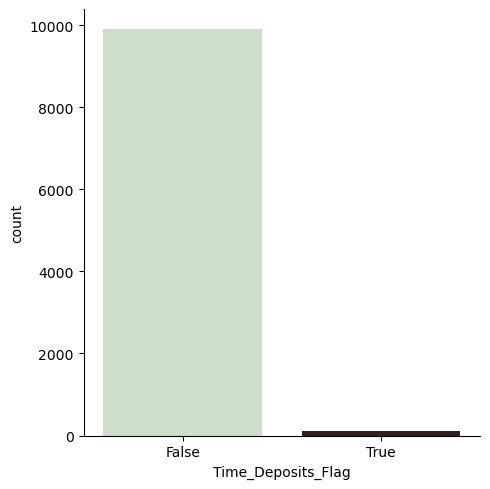

In [16]:

print(dataset["Time_Deposits_Flag"].value_counts(normalize=True))
sns.catplot(data = dataset, x = "Time_Deposits_Flag", kind = "count", palette = "ch:.79")
plt.show()